In [1]:
import jax
import jax.numpy as jnp
from jax import pmap, vmap, jit, config
from functools import partial
import numpy as np
import time

#config.update("jax_enable_x64", True)

FP=jnp.float32

In [2]:
%load_ext tensorboard

In [3]:
print(jax.default_backend())
print(jax.devices())

gpu
[CudaDevice(id=0)]


In [4]:
@jit
def pown(x, n):
    """
    Compute x^n using binary exponentiation (exponentiation by squaring).
    
    Args:
        x: Base value (numeric type)
        n: Integer exponent
        
    Returns:
        x raised to the power of n
    """
    if n == 0:
        return type(x)(1)  # Return 1 in the same type as x
    
    # Handle negative exponent safely (including INT_MIN)
    neg = n < 0
    # Convert to absolute value safely
    exp = abs(n)
    
    result = type(x)(1)
    base = x
    
    while exp:
        if exp & 1:  # If current bit is set
            result = result * base
        base = base * base
        exp >>= 1
    
    if neg:
        return type(x)(1) / result
    return result
@jit
def christoffel(a, Q, rs, x, v):
    x0 = x[1]**3
    x1 = rs*x0
    x2 = Q**2
    x3 = x[1]**2
    x4 = x2*x3
    x5 = a**2
    x6 = jnp.cos(x[2])
    x7 = x6**2
    x8 = x5*x7
    x9 = rs*x[1]
    x10 = -x1 + x2*x8 + x4 - x8*x9
    x11 = x2 - x9
    x12 = jnp.sin(x[2])
    x13 = x12**2
    x14 = x13*x5
    x15 = x3 + x8
    x16 = x14 + x15
    x17 = x11*x16
    x18 = x10*x17
    x19 = x14 - x2 - x5 + x8 + x9
    x20 = -x19
    x21 = x[1]**6
    x22 = a**4
    x23 = x22*x3
    x24 = x[1]**4
    x25 = 2*x5
    x26 = a**6
    x27 = x14*x24
    x28 = x13*x23
    x29 = x1*x14
    x30 = jnp.cos(4*x[2])
    x31 = (1/8)*x30
    x32 = 1/8 - x31
    x33 = x22*x32
    x34 = x14*x4
    x35 = x2*x22
    x36 = x21 - x23*x32 + 2*x23*x7 + x23 + x24*x25 + x24*x8 - x26*x32 + x26*x7 - x27 - x28 + x29 - x32*x35 + x33*x9 - x34
    x37 = a*v[0]
    x38 = x14*x9
    x39 = -x14*x3 + x24
    x40 = x22 + x25*x3
    x41 = -x13*x2*x5 - x13*x22 + x38 + x39 + x40
    x42 = 2*x13*x22
    x43 = 2*x3
    x44 = x14*x41 + x15*(-2*x14*x2 - x14*x43 + x24 + 2*x38 + x40 - x42)
    x45 = -x11*x16
    x46 = x12*x6
    x47 = 2*v[2]
    x48 = 2*x[1]
    x49 = rs*x15
    x50 = x11*x48 + x49
    x51 = x10*x14
    x52 = x50*x51
    x53 = x15*x48
    x54 = -x14
    x55 = x11 + x3 + x5
    x56 = x48*(x54 + x55) + x49 - x53
    x57 = x14*x49 - x41*x48 + x53*(x25 + x43 + x54)
    x58 = v[3]*x13
    x59 = x15**2
    x60 = x[1]**5
    x61 = x22*x9
    x62 = x24*x5
    x63 = x12**4
    x64 = 2*x13
    x65 = 1/(x59*(-rs*x60 - x1*x25 + x2*x24 + x21 + x23*x63 + 3*x23 + x25*x4 + x26*x63 - x26*x64 + x26 - 2*x27 - 4*x28 + 2*x29 - 2*x34 + x35*x63 - x35*x64 + x35 + x42*x9 - x61*x63 - x61 + 3*x62))
    x66 = x55**2
    x67 = v[1]**2
    x68 = 2*x[2]
    x69 = x5*jnp.sin(x68)
    x70 = v[2]*x55
    x71 = x59*x70
    x72 = v[0]**2
    x73 = v[3]**2
    x74 = 1/(x15**3*x55)
    x75 = jnp.cos(x68)
    x76 = x5*x75
    x77 = rs*x26
    x78 = x35*x[1]
    x79 = (1/2)*rs
    x80 = rs*x23
    x81 = x0*x2*x25
    x82 = x30 + 1
    x83 = x10 + x22*x7 + x3*x5 + x3*x8 - x33 + x39

    ch0 = x65*(a*x46*x47*(-v[3]*(x10*x44 + x36*x45) - x37*(x18 + x20*x36)) + v[1]*(-a*x58*(x10*x57 + x36*x50) + v[0]*(x36*x56 + x52)))
    ch1 = x74*(-x37*x50*x58*x66 + (1/2)*x59*x67*(x15*(-rs + 2*x[1]) - x48*x55) + (1/2)*x66*(x13*x57*x73 + x56*x72) + x71*(v[1]*x69 + x70*x[1]))
    ch2 = x74*(x46*x55*(2*v[3]*x17*x37 + x19*x5*x72 + x44*x73) - 1/8*x67*x69*(x43 + x5 + x76)**2 + x71*(-v[1]*x48 + (1/2)*v[2]*x69))
    ch3 = x65*(v[1]*x12*(v[3]*(x52 - x57*x83) + x37*(-rs*x21 + 2*x2*x60 + x23*x75*x79 - x24*x76*x79 + (1/16)*x30*x77 + (1/4)*x30*x78 - x31*x80 - x62*x79 + (15/32)*x75*x77 + x75*x78 + x75*x81 + (1/8)*x77*x82 + (1/32)*x77*jnp.cos(6*x[2]) + (3/16)*x77 + (3/4)*x78 + (1/4)*x80*x82 + (1/8)*x80 + x81)) + x47*x6*(-v[3]*(x14*x18 + x44*x83) + x37*(x20*x51 + x45*x83)))/x12

    return jnp.array([ch0, ch1, ch2, ch3])
@jit
def RK6(a, Q, rs, x, v, de):

    ch=christoffel(a, Q, rs, x, v);


    kx1 = v
    kv1 = ch
    
    x1 = x + kx1 * (de / 5.0)
    v1 = v + kv1 * (de / 5.0)

    ch=christoffel(a, Q, rs, x1, v1)

    kx2 = v1
    kv2 = ch

    x1 = x + kx1 * (de * (3.0 / 40.0)) + kx2 * (de * (9.0 / 40.0))
    v1 = v + kv1 * (de * (3.0 / 40.0)) + kv2 * (de * (9.0 / 40.0))


    ch=christoffel(a, Q, rs, x1, v1)


    kx3 = v1
    kv3 = ch

    x1 = x + (kx1 * (44.0 / 45.0) - kx2 * (56.0 / 15.0) + kx3 * (32.0 / 9.0)) * de
    v1 = v + (kv1 * (44.0 / 45.0) - kv2 * (56.0 / 15.0) + kv3 * (32.0 / 9.0)) * de
    

    ch=christoffel(a, Q, rs, x1, v1)

    kx4 = v1
    kv4 = ch

    x1 = x + (kx1 * (19372.0 / 6561.0) - kx2 * (25360.0 / 2187.0) + kx3 * (64448.0 / 6561.0) - kx4 * (212.0 / 729.0)) * de
    v1 = v + (kv1 * (19372.0 / 6561.0) - kv2 * (25360.0 / 2187.0) + kv3 * (64448.0 / 6561.0) - kv4 * (212.0 / 729.0)) * de

    ch=christoffel(a, Q, rs, x1, v1)

    kx5 = v1
    kv5 = ch
    
    x1 = x + (kx1 * (9017.0 / 3168.0) - kx2 * (355.0 / 33.0) + kx3 * (46732.0 / 5147.0) + kx4 * (49.0 / 176.0) - kx5 * (5103.0 / 18656.0)) * de
    v1 = v + (kv1 * (9017.0 / 3168.0) - kv2 * (355.0 / 33.0) + kv3 * (46732.0 / 5147.0) + kv4 * (49.0 / 176.0) - kv5 * (5103.0 / 18656.0)) * de
    

    ch=christoffel(a, Q, rs, x1, v1)

    kx6 = v1
    kv6 = ch

    x1 = x + (kx1 * (35.0 / 384.0) + kx3 * (500.0 / 1113.0) + kx4 * (125.0 / 192.0) - kx5 * (2187.0 / 6784.0) + kx6 * (11.0 / 84.0)) * de
    v1 = v + (kv1 * (35.0 / 384.0) + kv3 * (500.0 / 1113.0) + kv4 * (125.0 / 192.0) - kv5 * (2187.0 / 6784.0) + kv6 * (11.0 / 84.0)) * de

    ch = christoffel(a, Q, rs, x1, v1);

    kx7 = v1
    kv7 = ch

    x = x + (kx1 * (5179.0 / 57600.0) + kx3 * (7571.0 / 16695.0) + kx4 * (393.0 / 640.0) - kx5 * (92097.0 / 339200.0) + kx6 * (187.0 / 2100.0) + kx7 * (1.0 / 40.0)) * de
    v = v + (kv1 * (5179.0 / 57600.0) + kv3 * (7571.0 / 16695.0) + kv4 * (393.0 / 640.0) - kv5 * (92097.0 / 339200.0) + kv6 * (187.0 / 2100.0) + kv7 * (1.0 / 40.0)) * de
    
    return x,v

@jit
def RK6_de(a, Q, rs, x, v, de, de0, err):

    ch=christoffel(a, Q, rs, x, v);


    kx1 = v
    kv1 = ch
    
    x1 = x + kx1 * (de / 5.0)
    v1 = v + kv1 * (de / 5.0)

    ch=christoffel(a, Q, rs, x1, v1)

    kx2 = v1
    kv2 = ch

    x1 = x + kx1 * (de * (3.0 / 40.0)) + kx2 * (de * (9.0 / 40.0))
    v1 = v + kv1 * (de * (3.0 / 40.0)) + kv2 * (de * (9.0 / 40.0))


    ch=christoffel(a, Q, rs, x1, v1)


    kx3 = v1
    kv3 = ch

    x1 = x + (kx1 * (44.0 / 45.0) - kx2 * (56.0 / 15.0) + kx3 * (32.0 / 9.0)) * de
    v1 = v + (kv1 * (44.0 / 45.0) - kv2 * (56.0 / 15.0) + kv3 * (32.0 / 9.0)) * de
    

    ch=christoffel(a, Q, rs, x1, v1)

    kx4 = v1
    kv4 = ch

    x1 = x + (kx1 * (19372.0 / 6561.0) - kx2 * (25360.0 / 2187.0) + kx3 * (64448.0 / 6561.0) - kx4 * (212.0 / 729.0)) * de
    v1 = v + (kv1 * (19372.0 / 6561.0) - kv2 * (25360.0 / 2187.0) + kv3 * (64448.0 / 6561.0) - kv4 * (212.0 / 729.0)) * de

    ch=christoffel(a, Q, rs, x1, v1)

    kx5 = v1
    kv5 = ch
    
    x1 = x + (kx1 * (9017.0 / 3168.0) - kx2 * (355.0 / 33.0) + kx3 * (46732.0 / 5147.0) + kx4 * (49.0 / 176.0) - kx5 * (5103.0 / 18656.0)) * de
    v1 = v + (kv1 * (9017.0 / 3168.0) - kv2 * (355.0 / 33.0) + kv3 * (46732.0 / 5147.0) + kv4 * (49.0 / 176.0) - kv5 * (5103.0 / 18656.0)) * de
    

    ch=christoffel(a, Q, rs, x1, v1)

    kx6 = v1
    kv6 = ch

    x1 = x + (kx1 * (35.0 / 384.0) + kx3 * (500.0 / 1113.0) + kx4 * (125.0 / 192.0) - kx5 * (2187.0 / 6784.0) + kx6 * (11.0 / 84.0)) * de
    v1 = v + (kv1 * (35.0 / 384.0) + kv3 * (500.0 / 1113.0) + kv4 * (125.0 / 192.0) - kv5 * (2187.0 / 6784.0) + kv6 * (11.0 / 84.0)) * de

    ch = christoffel(a, Q, rs, x1, v1);

    kx7 = v1
    kv7 = ch

    x = x + (kx1 * (5179.0 / 57600.0) + kx3 * (7571.0 / 16695.0) + kx4 * (393.0 / 640.0) - kx5 * (92097.0 / 339200.0) + kx6 * (187.0 / 2100.0) + kx7 * (1.0 / 40.0)) * de
    v = v + (kv1 * (5179.0 / 57600.0) + kv3 * (7571.0 / 16695.0) + kv4 * (393.0 / 640.0) - kv5 * (92097.0 / 339200.0) + kv6 * (187.0 / 2100.0) + kv7 * (1.0 / 40.0)) * de

    errx = jnp.linalg.norm(x - x1, ord=np.inf)
    errv = jnp.linalg.norm(v - v1, ord=np.inf)

    de_new = lax.cond(
        err == 0,
        lambda _: 2*de,
        lambda _: de * jnp.clip(0.9 * (err/(errx+errv))**0.2, 0.1, 2.0),
        operand=None
    )
    
    return x,v,de_new
@jit
def step_size(de0, err, a, Q, rs, x, v):
    """
    Compute adaptive step size based on Christoffel symbols and error tolerance.
    
    Args:
        de0: Reference/maximum step size
        err: Error tolerance
        a: Parameter for christoffel function
        Q: Parameter for christoffel function  
        rs: Parameter for christoffel function
        x: Position array
        v: Velocity array
        
    Returns:
        Adjusted step size
    """
    # Compute Christoffel symbols
    ch = christoffel(a, Q, rs, x, v)
    
    # Sum of absolute values of Christoffel symbols
    sum_abs_ch = jnp.sum(jnp.abs(ch))
    
    # Compute proposed step size
    de = jnp.sqrt(err / sum_abs_ch)
    
    # Apply safety constraints
    # Handle NaN case first (if sum_abs_ch was 0 or very small)
    #de_nan_safe = jnp.where(jnp.isnan(de), de0 / 10, de)
    
    # Then handle the > de0 case
    #de_final = jnp.where(de_nan_safe > de0, de0, de_nan_safe)

    de_final=de
    return de_final
    
@jit
def step(de0, err, a, Q, rs, x, v, de):
    #x,v,de = RK6_de(a, Q, rs, x, v, de, de0, err)
    
    x,v = RK6(a, Q, rs, x, v, de)
    #de = step_size(de0, err, a, Q, rs, x, v)
    
    return x,v,de


In [25]:
# Sphere boundary checks
#@jit
def gomb_be(sugar, x):
    """
    Check if point is inside sphere (x[1] < sugar).
    
    Args:
        sugar: Sphere radius
        x: Position array [x0, x1, x2, ...]
    
    Returns:
        Boolean: True if inside sphere
    """
    return x[1] - sugar<0

def gomb_ki(sugar, x):
    """
    Check if point is inside sphere (x[1] < sugar).
    
    Args:
        sugar: Sphere radius
        x: Position array [x0, x1, x2, ...]
    
    Returns:
        Boolean: True if inside sphere
    """
    return x[1] - sugar>0

# Disk crossing detection functions
#@jit

def disk1(sugar_kicsi, sugar_nagy, x):
    """
    Check if trajectory crosses disk in both directions (Minkowski disk crossing).
    
    Args:
        sugar_kicsi: Inner radius
        sugar_nagy: Outer radius  
        x: position array
        
    Returns:
        Boolean: True if crosses disk in either direction
    """
    # Check if x1[1] is in the radial range
    in_radial_range = jnp.maximum((sugar_kicsi - x[1]), (x[1] - sugar_nagy))
    
    # asin(1.0) = π/2
    half_pi = jnp.pi / 2
    
    # Check both crossing directions
    crosses_up = jnp.abs(x[2] - half_pi)-0.01
    
    return jnp.maximum(crosses_up,in_radial_range)<0

def disk2(sugar_kicsi, sugar_nagy, x):
    """
    Check if trajectory crosses disk in both directions (Minkowski disk crossing).
    
    Args:
        sugar_kicsi: Inner radius
        sugar_nagy: Outer radius  
        x: position array
        
    Returns:
        Boolean: True if crosses disk in either direction
    """
    # Check if x1[1] is in the radial range
    in_radial_range = jnp.maximum((sugar_kicsi - x[1]), (x[1] - sugar_nagy))
    
    # asin(1.0) = π/2
    half_pi = jnp.pi / 2
    
    # Check both crossing directions
    crosses_up = jnp.abs(x[2] - half_pi)-0.01
    
    return jnp.maximum(crosses_up,in_radial_range)<0
# Index conversion function
@jit
def ijk_to_n(i, j, k, MAGAS, D):
    """
    Convert 3D indices to linear index.
    
    Args:
        i, j, k: 3D indices
        MAGAS: Height dimension (from hole.MAGAS)
        D: Depth dimension (constant D)
        
    Returns:
        Linear index
    """
    return i * MAGAS * D + j * D + k

In [26]:
@jit
def ijk_to_vec_mink_zoom(i, j, SZELESregi, MAGASregi, ikezd, jkezd, iveg, kepernyo_tav,kepernyo_high,SZELES,MAGAS):
    x = kepernyo_tav;
        
    ir = FP(ikezd) + (FP(i) / FP(SZELES)) * (FP(iveg) - FP(ikezd));
    jr = FP(jkezd) + (FP(j) / FP(SZELES)) * (FP(iveg) - FP(ikezd));

    y = (kepernyo_high / MAGASregi) * (FP(MAGASregi) / 2 - FP(jr));
    z = (kepernyo_high / MAGASregi) * (FP(ir) - FP(SZELESregi) / 2);

    norm = jnp.sqrt(x * x + y * y + z * z);
        
    return jnp.array([1.0, x / norm, y / norm, z / norm])

In [27]:
#bug to bug free translation
@jit
def ijk_to_vec_zoom(i, j, Omega, SZELESregi, MAGASregi, ikezd, jkezd, iveg,kepernyo_tav,kepernyo_high,SZELES,MAGAS, a, Q, rs, r_0, theta_0):
    x = ijk_to_vec_mink_zoom(i, j,SZELESregi,MAGASregi,ikezd,jkezd,iveg,kepernyo_tav,kepernyo_high,SZELES,MAGAS)
    phi = jnp.linalg.norm(Omega, ord=2)
    

    u=jnp.where(phi == 0.0, jnp.array([1.0,0.0,0.0]), Omega/phi)


    x1 = (jnp.cos(phi) + u[0] * u[0] * (1 - jnp.cos(phi))) * x[1] + (u[0] * u[1] * (1 - jnp.cos(phi)) - u[2] * jnp.sin(phi)) * x[2] + (u[0] * u[2] * (1 - jnp.cos(phi)) + u[1] * jnp.sin(phi)) * x[3]
    x2 = (u[0] * u[1] * (1 - jnp.cos(phi) + u[2] * jnp.sin(phi))) * x[1] + (jnp.cos(phi) + u[1] * u[1] * (1 - jnp.cos(phi))) * x[2] + (u[1] * u[2] * (1 - jnp.cos(phi) + u[0] * jnp.sin(phi))) * x[3]
    x3 = (u[0] * u[2] * (1 - jnp.cos(phi)) - u[1] * jnp.sin(phi)) * x[1] + (u[1] * u[2] * (1 - jnp.cos(phi)) + u[0] * jnp.sin(phi)) * x[2] + (jnp.cos(phi) + u[2] * u[2] * (1 - jnp.cos(phi))) * x[3]
    
    #bug to bug version
    #x1 = (jnp.cos(phi) + u[0] * u[0] * (1 - jnp.cos(phi))) * x[1] + (u[0] * u[1] * (1 - jnp.cos(phi)) - u[2] * jnp.sin(phi)) * x[2] + (u[0] * u[2] * (1 - jnp.cos(phi)) + u[1] * jnp.sin(phi)) * x[3]
    #x2 = (u[0] * u[1] * (1 - jnp.cos(phi) + u[2] * jnp.sin(phi))) * x1 + (jnp.cos(phi) + u[1] * u[1] * (1 - jnp.cos(phi))) * x[2] + (u[1] * u[2] * (1 - jnp.cos(phi) + u[0] * jnp.sin(phi))) * x[3]
    #x3 = (u[0] * u[2] * (1 - jnp.cos(phi)) - u[1] * jnp.sin(phi)) * x1 + (u[1] * u[2] * (1 - jnp.cos(phi)) + u[0] * jnp.sin(phi)) * x2 + (jnp.cos(phi) + u[2] * u[2] * (1 - jnp.cos(phi))) * x[3]
    
    
    x=jnp.array([x[0],x1,x2,x3])

    delta = r_0 * r_0 - 4 * rs * r_0 + a * a + Q * Q
    rho = jnp.sqrt(r_0 * r_0 + a * a * jnp.cos(theta_0) * jnp.cos(theta_0))

    x0 = x[0] * (a * a + r_0 * r_0) * rho / ((a * a * jnp.cos(theta_0) * jnp.cos(theta_0) + r_0 * r_0) * jnp.sqrt(delta)) + x[3] * a * rho / (jnp.sqrt(delta) * (a * a * jnp.cos(theta_0) * jnp.cos(theta_0) + r_0 * r_0))
    x1 = jnp.sqrt(delta) / rho * x[1]
    x2 = x[2] / rho
    x3 = x[0] * a * rho * jnp.sin(theta_0) / (a * a * jnp.cos(theta_0) * jnp.cos(theta_0) + r_0 * r_0) + x[3] * rho / (jnp.sin(theta_0) * (r_0 * r_0 + a * a * jnp.cos(theta_0) * jnp.cos(theta_0)));
    #bug to bug translation
    #x3 = x0 * a * rho * jnp.sin(theta_0) / (a * a * jnp.cos(theta_0) * jnp.cos(theta_0) + r_0 * r_0) + x[3] * rho / (jnp.sin(theta_0) * (r_0 * r_0 + a * a * jnp.cos(theta_0) * jnp.cos(theta_0)));
    
    x=jnp.array([x0,x1,x2,x3])


    return x

In [28]:
from jax import lax
@jit
def ray_step_good(i, j, SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0,
             kepernyo_high, kepernyo_tav, sugar_ki,
             gyuru_sugar_kicsi, gyuru_sugar_nagy,
             SZELESregi, MAGASregi, ikezd, jkezd, iveg):
    """
    Pure JAX version of your ray-stepper.
    """

    # initial direction vector
    v = ijk_to_vec_zoom(i, j, Omega, SZELESregi, MAGASregi,
                        ikezd, jkezd, iveg,
                        kepernyo_tav, kepernyo_high,
                        SZELES, MAGAS, a, Q, rs, x[1], x[2])

    de = de0

    x, v, de = step(de0, errormax, a, Q, rs, x, v, de)

    # Schwarzschild radius test
    disc = rs * rs - 4 * (a * a + Q * Q)
    sugar_be = jnp.where(disc > 0.0,
                         (rs + jnp.sqrt(disc)) / 2 + 0.001,
                         0.0)

    sugar_kicsi = gyuru_sugar_kicsi
    sugar_nagy = gyuru_sugar_nagy

    def cond_fun(state):
        x, v, de, idokorlat, outval = state
        return jnp.logical_and(outval == -99,  # keep looping if not decided
                               idokorlat < jnp.int32(1.0 / errormax))

    def body_fun(state):
        x, v, de, idokorlat, outval = state

        # compute conditions
        out1 = jnp.where(gomb_be(sugar_be, x), -1, -99)
        out2 = jnp.where((out1 == -99) & gomb_ki(sugar_ki, x), 0, out1)
        out3 = jnp.where((out2 == -99) & disk1(sugar_kicsi, sugar_nagy, x), -3, out2)
        out4 = jnp.where((out3 == -99) & disk2(sugar_kicsi, sugar_nagy, x), 3, out3)
        isnan = jnp.any(jnp.isnan(x))
        isinf = jnp.any(jnp.isinf(x))
        out5 = jnp.where((out4 == -99) & (isnan | isinf), 0,out4)# out4)

        # step again if still undecided
        x_new, v_new, de_new = step(de0, errormax, a, Q, rs, x, v, de)

        return (x_new, v_new, de_new, idokorlat + 1, out5)

    # initial state (use -99 as “undecided”)
    state0 = (x, v, de, 0, -99)
    x_f, v_f, de_f, idok_f, out_f = lax.while_loop(cond_fun, body_fun, state0)

    # if loop ends without hitting anything, return -2
    return jnp.where(out_f == -99, -2, out_f)


In [29]:
from jax import lax
@jit
def ray_step_2(i, j, SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0,
             kepernyo_high, kepernyo_tav, sugar_ki,
             gyuru_sugar_kicsi, gyuru_sugar_nagy,
             SZELESregi, MAGASregi, ikezd, jkezd, iveg):
    """
    Pure JAX version of your ray-stepper.
    """

    # initial direction vector
    v = ijk_to_vec_zoom(i, j, Omega, SZELESregi, MAGASregi,
                        ikezd, jkezd, iveg,
                        kepernyo_tav, kepernyo_high,
                        SZELES, MAGAS, a, Q, rs, x[1], x[2])

    de = de0

    x, v, de = step(de0, errormax, a, Q, rs, x, v, de)

    # Schwarzschild radius test
    disc = rs * rs - 4 * (a * a + Q * Q)
    sugar_be = jnp.where(disc > 0.0,
                         (rs + jnp.sqrt(disc)) / 2 + 0.001,
                         0.0)

    sugar_kicsi = gyuru_sugar_kicsi
    sugar_nagy = gyuru_sugar_nagy

    def cond_fun(state):
        x, v, de, idokorlat, outval = state
        return jnp.logical_and(outval == -99,  # keep looping if not decided
                               idokorlat < jnp.int32(0.33 / errormax))
    def body_fun(state):
        x, v, de, idokorlat, outval = state
    
        # Check all conditions once
        is_in_inner = gomb_be(sugar_be, x)
        is_out_outer = gomb_ki(sugar_ki, x)
        is_disk1 = disk1(sugar_kicsi, sugar_nagy, x)
        is_disk2 = disk2(sugar_kicsi, sugar_nagy, x)
        is_invalid = ~jnp.all(jnp.isfinite(x))
    
    # Determine outcome in priority order
        out_new = jnp.select(
            [is_in_inner, is_out_outer, is_disk1, is_disk2, is_invalid],
            [-1, 0, -3, 3, 0],
            default=-99
        )
    
        x_new, v_new, de_new = step(de0, errormax, a, Q, rs, x, v, de)
        return (x_new, v_new, de_new, idokorlat + 1, out_new)

    # initial state (use -99 as “undecided”)
    state0 = (x, v, de, 0, -99)
    x_f, v_f, de_f, idok_f, out_f = lax.while_loop(cond_fun, body_fun, state0)
    
    # if loop ends without hitting anything, return -2
    return jnp.where(out_f == -99, -2, out_f), idok_f


In [30]:
# Your existing vectorization should work:
vectorized_ray_step = jax.jit(vmap(
    vmap(ray_step_2,  # Change this to the new function name
         in_axes=(None, 0, None, None, None, None, None, None, None, None, None, 
                 None, None, None, None, None, None, None, None, None, None)),
    in_axes=(0, None, None, None, None, None, None, None, None, None, None,
            None, None, None, None, None, None, None, None, None, None)))# ,static_argnames=['SZELES', 'MAGAS', 'a', 'Q', 'rs', 'errormax', 'de0', 'kepernyo_high', 'kepernyo_tav', 'sugar_ki', 'gyuru_sugar_kicsi', 'gyuru_sugar_nagy', 'SZELESregi', 'MAGASregi'] )

def makeframe_T(SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg):
    start = time.time()


    # Apply to all coordinates
    i_coords = jnp.arange(SZELES)  # [0, 1, 2, ..., SZELES-1]
    j_coords = jnp.arange(MAGAS)   # [0, 1, 2, ..., MAGAS-1]


    
    # Apply to all coordinates
    SZIN, iter_max = vectorized_ray_step(i_coords, j_coords,SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg)
    
    SZIN.block_until_ready()
    end = time.time()
    print(end-start)

    return SZIN,iter_max

In [31]:
vectorized_ray_step_flat = jax.jit(vmap(ray_step_2, in_axes=(0, 0, None, None, None, None, 
                                                             None, None, None, None, None,
                                                             None, None, None, None, None, 
                                                             None, None, None, None, None)) )


def makeframe_Th(SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg):
    start = time.time()


    # Apply to all coordinates
    i_coords = jnp.repeat(jnp.arange(SZELES), MAGAS)  # [0,0,0,...,1,1,1,...,1023,1023,1023]
    j_coords = jnp.tile(jnp.arange(MAGAS), SZELES)    # [0,1,2,...,511,0,1,2,...,511,...]
    
    # Apply to all coordinates
    SZIN, iter_max = vectorized_ray_step_flat(i_coords, j_coords,SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg)
    
    SZIN.block_until_ready()
    end = time.time()
    print(end-start)

    return SZIN.reshape(SZELES, MAGAS),iter_max.reshape(SZELES, MAGAS)

In [32]:
kepernyoSZELES = 10240
kepernyoMAGAS = 5120


SZELES=1024
MAGAS=512

errormax = 0.0001
de0 = 0.01

rs = 0.05  # 2*rs = m

delta_a = 0.0001

a = 0.024#0.026  # rs / 2 - delta_a  # 0.0
Q = 0.0

t_0 = 0.0
r_0 = 0.9
theta_0 = 1.57 + 0.06  # ne legyen nulla
phi_0 = 0.0

kepernyo_high = 0.5
kepernyo_tav = 0.75  # 0.4 #0.75

sugar_ki = 1.01

gyuru_sugar_kicsi = 0.1
gyuru_sugar_nagy = 0.5

# D = 4 if you’re matching the array size in C++
x = jnp.array([t_0, r_0, theta_0, phi_0])

pi_cucc = np.arcsin(1) * 2  # == math.pi
Omega = jnp.array([ 0,pi_cucc,0 ])

SZELESregi = SZELES
MAGASregi = MAGAS

ikezd = 0
jkezd = 0
iveg = SZELES

In [33]:
"""
start = time.time()
i_coords = jnp.arange(SZELES)  # [0, 1, 2, ..., SZELES-1]
j_coords = jnp.arange(MAGAS)   # [0, 1, 2, ..., MAGAS-1]
vectorized_ray_step_compiled=vectorized_ray_step.lower(i_coords, j_coords, SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg).compile()
end = time.time()
print(end-start)

vectorized_ray_step_compiled.cost_analysis()['flops']
"""

"\nstart = time.time()\ni_coords = jnp.arange(SZELES)  # [0, 1, 2, ..., SZELES-1]\nj_coords = jnp.arange(MAGAS)   # [0, 1, 2, ..., MAGAS-1]\nvectorized_ray_step_compiled=vectorized_ray_step.lower(i_coords, j_coords, SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg).compile()\nend = time.time()\nprint(end-start)\n\nvectorized_ray_step_compiled.cost_analysis()['flops']\n"

20.055081129074097


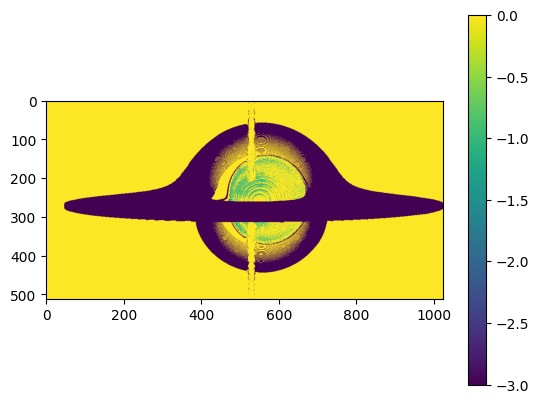

1455


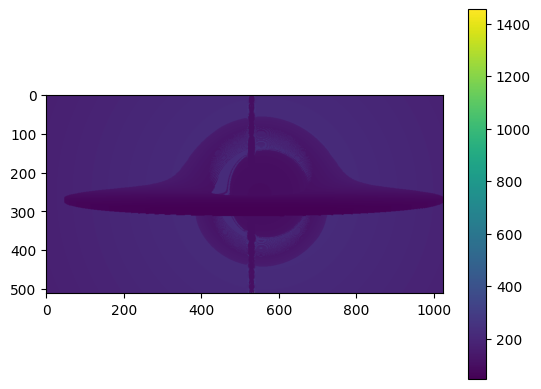

In [34]:

res,iters=makeframe_T(SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg)


import numpy as np
import matplotlib.pyplot as plt



plt.imshow(res.T)  # 'gray' colormap for grayscale image
plt.colorbar()                   # optional: show a color scale
plt.show()

print(jnp.max(iters))
plt.imshow(iters.T)  # 'gray' colormap for grayscale image
plt.colorbar()                   # optional: show a color scale
plt.show()

32.20214533805847


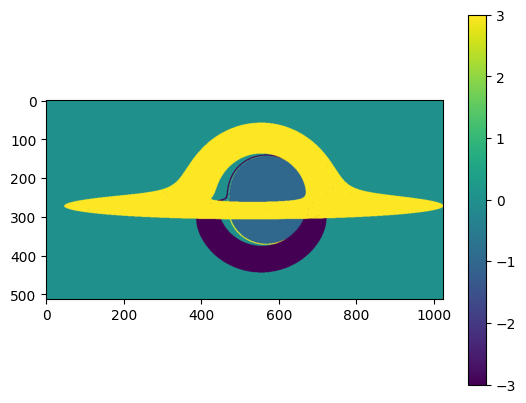

10623


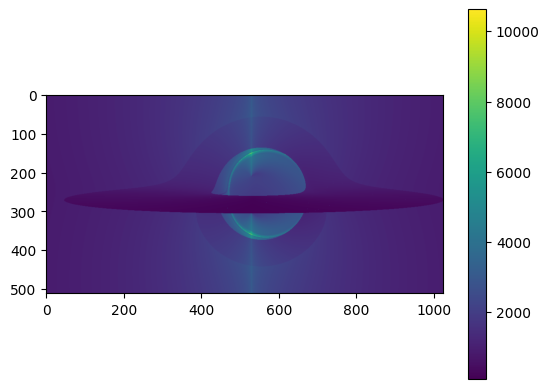

In [27]:

res,iters=makeframe_Th(SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg)


import numpy as np
import matplotlib.pyplot as plt



plt.imshow(res.T)  # 'gray' colormap for grayscale image
plt.colorbar()                   # optional: show a color scale
plt.show()

print(jnp.max(iters))
plt.imshow(iters.T)  # 'gray' colormap for grayscale image
plt.colorbar()                   # optional: show a color scale
plt.show()

In [45]:
1024*512

524288

In [150]:
iters.std()

Array(207.24068, dtype=float32)

5.157258987426758


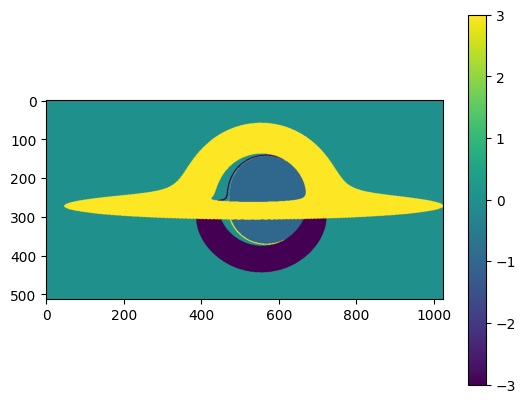

2753


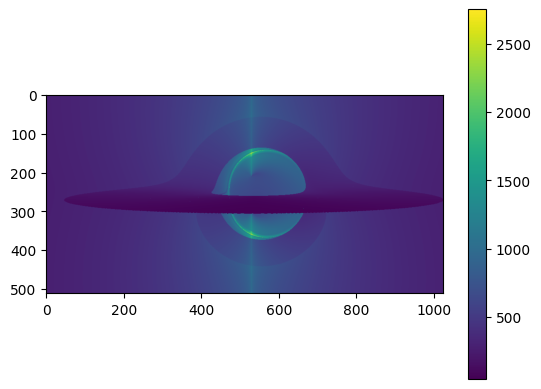

In [148]:


res,iters=makeframe_Th(SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg)


import numpy as np
import matplotlib.pyplot as plt



plt.imshow(res.T)  # 'gray' colormap for grayscale image
plt.colorbar()                   # optional: show a color scale
plt.show()

print(jnp.max(iters))
plt.imshow(iters.T)  # 'gray' colormap for grayscale image
plt.colorbar()                   # optional: show a color scale
plt.show()

In [113]:

hlo=vectorized_ray_step.lower(i_coords, j_coords,SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg).compiler_ir(dialect="hlo")
print(hlo.as_hlo_text()) 

HloModule jit_ray_step_2, entry_computation_layout={(s32[1024]{0}, s32[512]{0}, s32[], f32[4]{0}, f32[3]{0}, /*index=5*/f32[], f32[], f32[], f32[], f32[], /*index=10*/f32[], f32[], f32[], f32[], f32[], /*index=15*/s32[], s32[], s32[], s32[], s32[])->(s32[1024,512]{1,0}, s32[1024,512]{1,0})}

ijk_to_vec_mink_zoom.1 {
  constant.13 = f32[] constant(1)
  broadcast_in_dim.8 = f32[1024,512,1]{2,1,0} broadcast(constant.13), dimensions={}
  Arg_7.3 = f32[] parameter(7)
  div.26 = f32[1024,512]{1,0} broadcast(Arg_7.3), dimensions={}
  mul.19 = f32[] multiply(Arg_7.3, Arg_7.3)
  add.17 = f32[512]{0} broadcast(mul.19), dimensions={}
  Arg_8.3 = f32[] parameter(8)
  Arg_3.3 = s32[] parameter(3)
  convert_element_type.24 = f32[] convert(Arg_3.3)
  div.22 = f32[] divide(Arg_8.3, convert_element_type.24)
  mul.15 = f32[512]{0} broadcast(div.22), dimensions={}
  convert_element_type.25 = f32[] convert(Arg_3.3)
  constant.14 = f32[] constant(2)
  div.23 = f32[] divide(convert_element_type.25, constant

In [101]:
@jax.jit
def f(x):
    return x**410

f(10)

# Get HLO
hlo = f.lower(jnp.float32(10)).compiler_ir(dialect="hlo")
print(hlo.as_hlo_text()) 

HloModule jit_f, entry_computation_layout={(f32[])->f32[]}

ENTRY main.1 {
  x.1 = f32[] parameter(0)
  mul.12 = f32[] multiply(x.1, x.1)
  mul.13 = f32[] multiply(mul.12, mul.12)
  mul.14 = f32[] multiply(mul.13, mul.13)
  mul.15 = f32[] multiply(mul.12, mul.14)
  mul.16 = f32[] multiply(mul.14, mul.14)
  mul.17 = f32[] multiply(mul.15, mul.16)
  mul.18 = f32[] multiply(mul.16, mul.16)
  mul.19 = f32[] multiply(mul.18, mul.18)
  mul.20 = f32[] multiply(mul.19, mul.19)
  mul.21 = f32[] multiply(mul.17, mul.20)
  mul.22 = f32[] multiply(mul.20, mul.20)
  ROOT mul.23 = f32[] multiply(mul.21, mul.22)
}




In [85]:
@jax.jit
def f(x):
    return x**32

# Lower the computation
lowered = f.lower(jnp.ones((), jnp.float32))

# Lower and get XLA computation (not MLIR)
comp = f.lower(jnp.ones((), jnp.float32)).compiler_ir()
print(comp)

module @jit_f attributes {mhlo.num_partitions = 1 : i32, mhlo.num_replicas = 1 : i32} {
  func.func public @main(%arg0: tensor<f32>) -> (tensor<f32> {jax.result_info = "result"}) {
    %0 = stablehlo.multiply %arg0, %arg0 : tensor<f32>
    %1 = stablehlo.multiply %0, %0 : tensor<f32>
    %2 = stablehlo.multiply %1, %1 : tensor<f32>
    %3 = stablehlo.multiply %2, %2 : tensor<f32>
    %4 = stablehlo.multiply %3, %3 : tensor<f32>
    return %4 : tensor<f32>
  }
}



In [102]:

v_test = ijk_to_vec_zoom(12, 35, Omega, SZELESregi, MAGASregi,
                        ikezd, jkezd, iveg,
                        kepernyo_tav, kepernyo_high,
                        SZELES, MAGAS, a, Q, rs, x[1], x[2])
hlo = christoffel.lower(a, Q, rs, x, v_test).compiler_ir(dialect="hlo")
hlo_cost=christoffel.lower(a, Q, rs, x, v_test)
print(hlo.as_hlo_text())

HloModule jit_christoffel, entry_computation_layout={(f32[], f32[], f32[], f32[4]{0}, f32[4]{0})->f32[4]{0}}

ENTRY main.1 {
  constant.22 = f32[] constant(1)
  x.1 = f32[4]{0} parameter(3)
  slice.33 = f32[1]{0} slice(x.1), slice={[1:2]}
  squeeze.33 = f32[] reshape(slice.33)
  integer_pow.18 = f32[] multiply(squeeze.33, squeeze.33)
  a.1 = f32[] parameter(0)
  integer_pow.19 = f32[] multiply(a.1, a.1)
  slice.34 = f32[1]{0} slice(x.1), slice={[2:3]}
  squeeze.34 = f32[] reshape(slice.34)
  cos.4 = f32[] cosine(squeeze.34)
  integer_pow.20 = f32[] multiply(cos.4, cos.4)
  mul.202 = f32[] multiply(integer_pow.19, integer_pow.20)
  add.86 = f32[] add(integer_pow.18, mul.202)
  integer_pow.22 = f32[] multiply(add.86, add.86)
  rs.1 = f32[] parameter(2)
  neg.20 = f32[] negate(rs.1)
  slice.44 = f32[1]{0} slice(x.1), slice={[1:2]}
  squeeze.44 = f32[] reshape(slice.44)
  mul.268 = f32[] multiply(squeeze.44, squeeze.44)
  mul.269 = f32[] multiply(mul.268, mul.268)
  mul.270 = f32[] multipl

In [87]:

v_test = ijk_to_vec_zoom(12, 35, Omega, SZELESregi, MAGASregi,
                        ikezd, jkezd, iveg,
                        kepernyo_tav, kepernyo_high,
                        SZELES, MAGAS, a, Q, rs, x[1], x[2])
hlo_cost=christoffel.lower(a, Q, rs, x, v_test).compiler_ir().cost_analysis()
print(hlo_cost)

AttributeError: 'jaxlib.mlir._mlir_libs._mlir.ir.Module' object has no attribute 'cost_analysis'

In [124]:

res,iters=makeframe_T(SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg);


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[]
It arose in the jnp.arange argument 'stop'
The error occurred while tracing the function makeframe_T_inner at /tmp/ipykernel_6660/1621924158.py:8 for jit. This concrete value was not available in Python because it depends on the value of the argument SZELES.

See https://docs.jax.dev/en/latest/errors.html#jax.errors.ConcretizationTypeError

2753


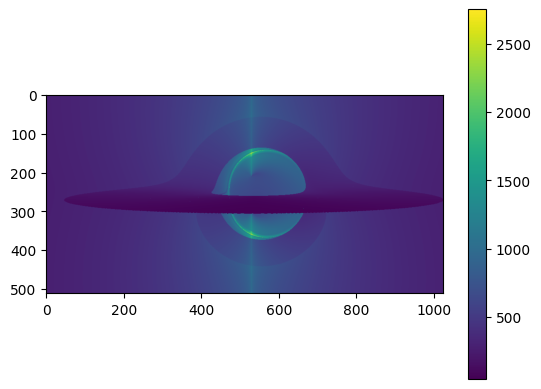

In [117]:
import numpy as np
import matplotlib.pyplot as plt


print(jnp.max(iters))
plt.imshow(iters.T)  # 'gray' colormap for grayscale image
plt.colorbar()                   # optional: show a color scale
plt.show()

In [78]:
res=makeframe_Tg(SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg);


23.279309272766113


In [23]:
i_coords = jnp.arange(SZELES)  # [0, 1, 2, ..., SZELES-1]
j_coords = jnp.arange(MAGAS)   # [0, 1, 2, ..., MAGAS-1]
with jax.profiler.trace("./jax-trace", create_perfetto_link=True):
    # Apply to all coordinates
    res = vectorized_ray_step(i_coords, j_coords,SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg)

    res.block_until_ready()
    #jax.profiler.stop_trace()


Open URL in browser: https://ui.perfetto.dev/#!/?url=http://127.0.0.1:9001/perfetto_trace.json.gz


127.0.0.1 - - [05/Oct/2025 16:07:41] code 404, message File not found
127.0.0.1 - - [05/Oct/2025 16:07:41] "POST /status HTTP/1.1" 404 -
127.0.0.1 - - [05/Oct/2025 16:07:41] "GET /perfetto_trace.json.gz HTTP/1.1" 200 -


AttributeError: 'tuple' object has no attribute 'block_until_ready'

In [35]:
"""with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
  # Run the operations to be profiled
  key = jax.random.key(0)
  x = jax.random.normal(key, (5000, 5000))
  y = x @ x
  y.block_until_ready()"""

'with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):\n  # Run the operations to be profiled\n  key = jax.random.key(0)\n  x = jax.random.normal(key, (5000, 5000))\n  y = x @ x\n  y.block_until_ready()'

In [89]:
szin=res
szin

Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32, weak_type=True)

In [90]:
"""
szin=np.empty((SZELES,MAGAS),dtype=np.float64)
for i in range(SZELES):
    for j in range(MAGAS):
        print(i,j)
        szin[i][j]=ray_step(i, j,SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg)
""" 

'\nszin=np.empty((SZELES,MAGAS),dtype=np.float64)\nfor i in range(SZELES):\n    for j in range(MAGAS):\n        print(i,j)\n        szin[i][j]=ray_step(i, j,SZELES, MAGAS, x, Omega, a, Q, rs, errormax, de0, kepernyo_high, kepernyo_tav, sugar_ki, gyuru_sugar_kicsi, gyuru_sugar_nagy, SZELESregi, MAGASregi, ikezd, jkezd, iveg)\n'

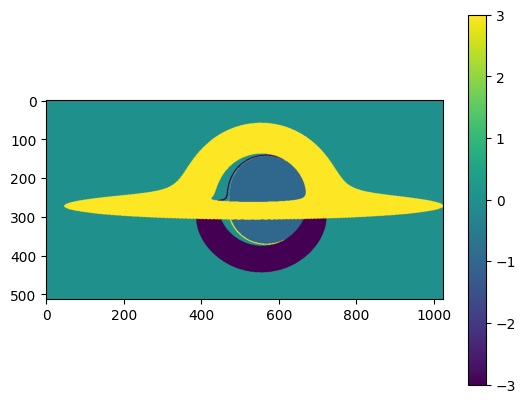

In [91]:
import numpy as np
import matplotlib.pyplot as plt



plt.imshow(szin.T)  # 'gray' colormap for grayscale image
plt.colorbar()                   # optional: show a color scale
plt.show()


In [15]:
from PIL import Image
import numpy as np

matrix=np.array(szin.T)
# Scale values to 0–255 if needed
matrix_scaled = (255 * (matrix - matrix.min()) / (matrix.ptp())).astype(np.uint8)

# Make a grayscale image
img = Image.fromarray(matrix_scaled, mode='L')

# Save as PNG
img.save("matrix.png")


In [16]:
from PIL import Image

from datetime import datetime
from math import log

import struct


now = datetime.now() # current date and time

im=[]

num_of_frames=100

for num in range(num_of_frames):

    xmax=0.0
    img = Image.new( 'RGB', (b,a), "black") # Create a new black image
    pixels = img.load() # Create the pixel map
    for i in range(img.size[0]):    # For every pixel:
        for j in range(img.size[1]):
            x=struct.unpack('f', file.read(4))[0]
            if(xmax<x):
                xmax=x
            if (x==0):
                pixels[i,j] = (0, 0, 0)
            elif(x==-1):
                pixels[i,j] = (0, 0, 0)#(255, 0, 0)#(255, 255, 255)#
            else:
                
                T=x/0.5*256*4
                r=1.1
                if((T//256)%3==0):
                    T=T%256
                    pixels[i,j] = (int(255-T/r), 0, 0)
                elif((T//256)%3==1):
                    T=T%256
                    pixels[i,j] = (0, int(255-T/r), 0)
                elif((T//256)%3==2):
                    T=T%256
                    pixels[i,j] = (0, 0, int(255-T/r))
                #pixels[i,j] = (0, 255, 0) ha 1 szinure akarjuk
                    
                
    im.append(img)
    
    #nevex="blackholle"+now.strftime("%m_%d_%Y_%H_%M_%S")+"__"+str(num)
    #windows#"C:\\Users\\elekp\\source\\repos\\kerr_class_szines_kep\\kerr_class_szines_kep\\kepekx\\blackholle"+now.strftime("%m_%d_%Y_%H_%M_%S")+"__"+str(num)
    #img.save(nevex+".png")
        
print(xmax)
#img.show()
neve="blackhole"
#"C:\\Users\\elekp\\source\\repos\\kerr_class_szines_kep\\kerr_class_szines_kep\\kepekx\\blackholle"+now.strftime("%m_%d_%Y_%H_%M_%S")

agif=Image.new( 'RGB', (b,a), "black")
agif=im[0]

for num in range(num_of_frames):
    im.append(im[num_of_frames-num-1])



agif.save(neve+".gif",save_all=True, append_images=im,loop=0)

print("kesz")

NameError: name 'b' is not defined